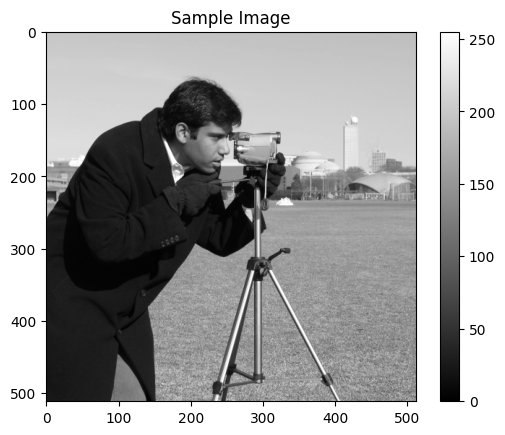

In [1]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load an example image
image = skimage.data.camera()

# Display the image
plt.imshow(image, cmap="gray")
plt.title("Sample Image")
plt.colorbar()
plt.show()

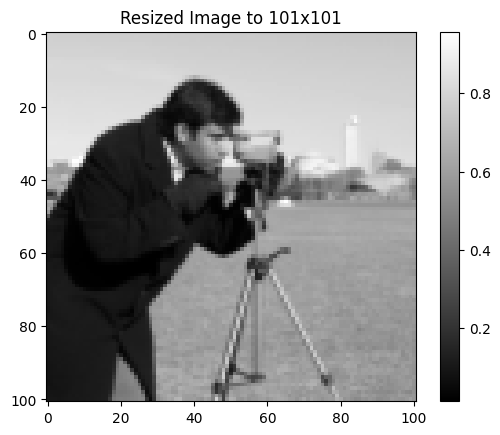

In [2]:
N_x, N_y = 101, 101

# Resize the image
resized_image = skimage.transform.resize(image, (N_x, N_y), anti_aliasing=True)

# Display the resized image
plt.imshow(resized_image, cmap="gray")
plt.title(f"Resized Image to {N_x}x{N_y}")
plt.colorbar()
plt.show()

#### In the following, we will use matshow which plots the color at pixels not at pixel intersection points

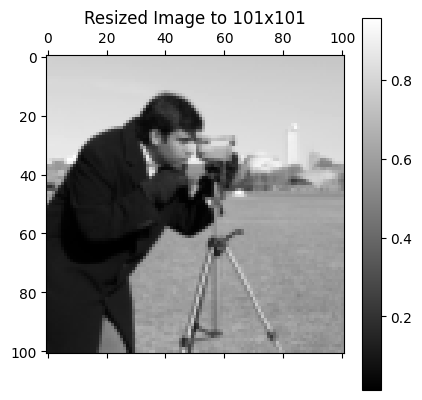

In [3]:
N_x, N_y = 101, 101

# Resize the image
resized_image = skimage.transform.resize(image, (N_x, N_y), anti_aliasing=True)

# Display the resized image
plt.matshow(resized_image, cmap="gray")
plt.title(f"Resized Image to {N_x}x{N_y}")
plt.colorbar()
plt.show()

#### handwritten Fourier Transform and inverse Fourier Transform based on nested loops

In [4]:
def FourierTransform_2d_slow(image, x, y, kx_grid, ky_grid):
    """
    Compute the 2D Fourier Transform manually

    Args:
        image (np.ndarray): 2D input array in spatial domain.
        x (np.ndarray): 1D array representing x positions.
        y (np.ndarray): 1D array representing y positions.
        kx_grid (np.ndarray): 2D grid of kx frequencies (from np.meshgrid).
        ky_grid (np.ndarray): 2D grid of ky frequencies (from np.meshgrid).

    Returns:
        np.ndarray: 2D Fourier Transform in the frequency domain.
    """
    Nx, Ny = len(x), len(y)  # Dimensions of spatial grid
    Nkx, Nky = kx_grid.shape  # Dimensions of frequency grid

    k_space_image = np.zeros((Nkx, Nky), dtype=complex)

    for u in range(Nkx):
        for v in range(Nky):
            ### Note: if kx_grid, ky_grid are generated with indexing="ij" (default is "xy")
            ### this line should be kx, ky = kx_grid[u, v], ky_grid[u, v]
            kx, ky = kx_grid[v, u], ky_grid[v, u]

            # Compute the phase factor for all spatial points at this frequency
            phase_factor = np.exp(-2j * np.pi * (kx * x[:, None] + ky * y[None, :]))

            # Compute the Fourier coefficient by summing over all spatial points
            k_space_image[u, v] = np.sum(image * phase_factor)
    return k_space_image

In [5]:
def InverseFourierTransform_2d_slow(k_space_image, x, y, kx_grid, ky_grid):
    """
    Compute the 2D Inverse Fourier Transform manually by looping over frequency indices.

    Args:
        k_space_image (np.ndarray): 2D input array in the frequency domain.
        x (np.ndarray): 1D array representing x positions.
        y (np.ndarray): 1D array representing y positions.
        kx_grid (np.ndarray): 2D grid of kx frequencies (from np.meshgrid).
        ky_grid (np.ndarray): 2D grid of ky frequencies (from np.meshgrid).

    Returns:
        np.ndarray: 2D Inverse Fourier Transform in the spatial domain.
    """
    Nkx, Nky = kx_grid.shape  # Dimensions of frequency grid
    Nx, Ny = len(x), len(y)  # Dimensions of spatial grid

    # Initialize the spatial domain image
    image = np.zeros((Nx, Ny), dtype=complex)

    for u in range(Nkx):
        for v in range(Nky):
            # Frequency positions
            kx, ky = kx_grid[v, u], ky_grid[v, u]  # Adjust indexing for "xy"

            # Compute the phase factor for all spatial points
            phase_factor = np.exp(2j * np.pi * (kx * x[:, None] + ky * y[None, :]))

            # Add the contribution of this frequency to all spatial points
            image += k_space_image[u, v] * phase_factor  # Sum contributions for all (i, j)

    # Normalize by the total number of frequency points
    image /= Nkx * Nky

    return image

# Mathematical Representation of Python's 2D FFT (`fft2`)

The 2D Fast Fourier Transform computes the discrete Fourier transform (DFT) of a 2D array and is typically implemented as:

$$
F(k_x, k_y) = \sum_{n_x=0}^{N_{kx}-1} \sum_{n_y=0}^{N_{ky}-1} f(n_x, n_y) \cdot e^{-2\pi i \left(\frac{k_x n_x}{N_{kx}} + \frac{k_y n_y}{N_{ky}}\right)}
$$

where:
- $f(n_x, n_y)$ is the input 2D array (position space),
- $F(k_x, k_y)$ is the output 2D array (momentum space),
- $N_{kx}$ and $N_{ky}$ are the dimensions of the 2D array in the $n_x$ and $n_y$ directions, respectively,
- $k_x$ and $k_y$ are the momentum indices in the $N_{kx}$- and $N_{ky}$-dimensional Fourier space,
- $i$ is the imaginary unit ($i^2 = -1$).

The Python `numpy.fft.fft2` function performs this transformation efficiently using the Cooley-Tukey FFT algorithm.

# Inverse 2D FFT (`ifft2`)

The inverse 2D FFT is defined as:

$$
f(n_x, n_y) = \frac{1}{N_{kx} N_{ky}} \sum_{k_x=0}^{N_{kx}-1} \sum_{k_y=0}^{N_{ky}-1} F(k_x, k_y) \cdot e^{2\pi i \left(\frac{k_x n_x}{N_{kx}} + \frac{k_y n_y}{N_{ky}}\right)}
$$

Here, the scaling factor $\frac{1}{N_{kx} N_{ky}}$ ensures the correct normalization for recovering the original input array.

# Note
1. (x,y) starts from (0,0)
2. x, y are both integers


In [6]:
Nx, Ny = 101, 101
x_array = np.arange(Nx) /100
y_array = np.arange(Ny) /100
kx = np.fft.fftfreq(Nx) *100
ky = np.fft.fftfreq(Ny) *100
kx_grid, ky_grid = np.meshgrid(kx,ky)

k_space_image_manual = FourierTransform_2d_slow(resized_image, x_array, y_array, kx_grid, ky_grid)

# Compute FFT using TensorFlow
resized_image_tf = tf.cast(resized_image, dtype=tf.complex64)
k_space_image_tf = tf.signal.fft2d(resized_image_tf)

# Compare Results
#print("TensorFlow FFT Result:\n", k_space_image_tf.numpy())
#print("\nManual FFT Result:\n", k_space_image_manual)

In [7]:
def arrays_are_equal(arr1, arr2, epsilon=1e-10):
    """
    Compare two numpy arrays to check if they are identical up to an error tolerance.

    Args:
        arr1 (np.ndarray): First array to compare.
        arr2 (np.ndarray): Second array to compare.
        epsilon (float): Tolerance for numerical differences. Defaults to 1e-10.

    Returns:
        bool: True if arrays are identical within the tolerance, False otherwise.
    """
    # Check if shapes match
    if arr1.shape != arr2.shape:
        return False

    # Compare element-wise with the given tolerance
    return np.all(np.abs(arr1 - arr2) <= epsilon)

In [8]:
arrays_are_equal(k_space_image_manual, k_space_image_tf.numpy(), epsilon=1e-5)

False

#### Note: they do not match in higher precisions

In [9]:
Nx, Ny = 101, 101
# coordinates are centered at 0
x_array2 = (np.arange(Nx) - (Nx - 1) / 2) / 100
y_array2 = (np.arange(Ny) - (Ny - 1) / 2) / 100
kx = np.fft.fftfreq(Nx) *100
ky = np.fft.fftfreq(Ny) *100
kx_grid, ky_grid = np.meshgrid(kx,ky)

k_space_centered_image_manual = FourierTransform_2d_slow(resized_image, x_array2, y_array2, kx_grid, ky_grid)

In [10]:
arrays_are_equal(k_space_image_manual, k_space_centered_image_manual, epsilon=1e-1)

False

# Effect of 2D Translation on the 2D Fourier Transform

Let $f(x, y)$ be the original spatial-domain function, and $F(k_x, k_y)$ its corresponding 2D Fourier Transform.

## Original 2D Fourier Transform
The Fourier Transform of $f(x, y)$ is given by:

$$
F(k_x, k_y) = \int_{-\infty}^\infty \int_{-\infty}^\infty f(x, y) e^{-2\pi i (k_x x + k_y y)} \, dx \, dy
$$

## After Translation
Suppose the function $f(x, y)$ is translated by $\Delta x$ along the $x$-axis and $\Delta y$ along the $y$-axis. The translated function is:

$$
f'(x, y) = f(x - \Delta x, y - \Delta y)
$$

The 2D Fourier Transform of the translated function $f'(x, y)$ is:

$$
F'(k_x, k_y) = \int_{-\infty}^\infty \int_{-\infty}^\infty f(x - \Delta x, y - \Delta y) e^{-2\pi i (k_x x + k_y y)} \, dx \, dy
$$

## Substitution for Translation
Let $u = x - \Delta x$ and $v = y - \Delta y$, so that $du = dx$ and $dv = dy$. Substituting these into the integral:

$$
F'(k_x, k_y) = \int_{-\infty}^\infty \int_{-\infty}^\infty f(u, v) e^{-2\pi i [k_x (u + \Delta x) + k_y (v + \Delta y)]} \, du \, dv
$$

Expanding the exponent:

$$
F'(k_x, k_y) = \int_{-\infty}^\infty \int_{-\infty}^\infty f(u, v) e^{-2\pi i (k_x u + k_y v)} e^{-2\pi i (k_x \Delta x + k_y \Delta y)} \, du \, dv
$$

## Factorization
The term $e^{-2\pi i (k_x \Delta x + k_y \Delta y)}$ is independent of $u$ and $v$, so it can be factored out:

$$
F'(k_x, k_y) = e^{-2\pi i (k_x \Delta x + k_y \Delta y)} \int_{-\infty}^\infty \int_{-\infty}^\infty f(u, v) e^{-2\pi i (k_x u + k_y v)} \, du \, dv
$$

The remaining integral is simply $F(k_x, k_y)$, the original Fourier Transform. Thus:

$$
F'(k_x, k_y) = e^{-2\pi i (k_x \Delta x + k_y \Delta y)} F(k_x, k_y)
$$

## Result
The 2D Fourier Transform of a translated function $f(x - \Delta x, y - \Delta y)$ is:

$$
F'(k_x, k_y) = F(k_x, k_y) \cdot e^{-2\pi i (k_x \Delta x + k_y \Delta y)}
$$

## Note
- A translation in the spatial domain results in a **phase shift** in the frequency domain.
- The phase shift depends on the translation amounts $\Delta x$ and $\Delta y$, and the corresponding frequency components $k_x$ and $k_y$.


In [11]:
def FourierTransform_after_2d_translation(k_space_image, kx_grid, ky_grid, shift_x, shift_y):
    """
    Apply a 2D shift to the Fourier Transform using pre-generated kx and ky grids.

    Args:
        k_space (np.ndarray): 2D Fourier Transform (output of handwritten_2dft_with_grids_fixed).
        kx_grid (np.ndarray): 2D grid of kx frequencies (from np.meshgrid).
        ky_grid (np.ndarray): 2D grid of ky frequencies (from np.meshgrid).
        shift_x (float): Horizontal shift in spatial domain.
        shift_y (float): Vertical shift in spatial domain.

    Returns:
        np.ndarray: Adjusted 2D Fourier Transform after applying the shifts.
    """
    # Compute the phase factor using the pre-generated frequency grids
    phase_factor = np.exp(-2j * np.pi * (kx_grid * shift_x + ky_grid * shift_y))

    # Apply the phase factor to the Fourier Transform
    k_space_image_translated = k_space_image * phase_factor

    return k_space_image_translated

In [19]:
arrays_are_equal(FourierTransform_after_2d_translation(k_space_image_manual, kx_grid, ky_grid, -0.5, -0.5), k_space_centered_image_manual, epsilon=1e-10)

True

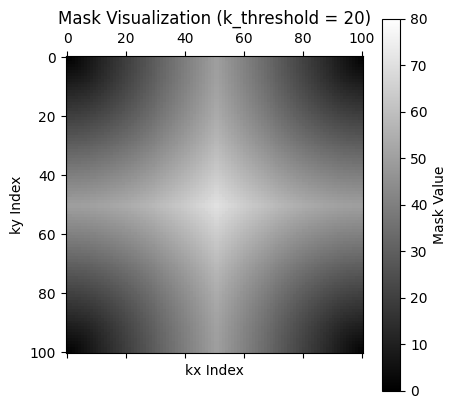

In [42]:
# Visualize the momentum grid
plt.matshow(np.sqrt(kx_grid**2 + ky_grid**2), cmap="gray", vmin=0, vmax=80)  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Momentum grid")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

In [20]:
# Create the high-k pass filter (0 if k < k_threshold, 1 otherwise)
k_threshold = 20
k_space_mask = np.where(np.sqrt(kx_grid**2 + ky_grid**2) < k_threshold, 0, 1)

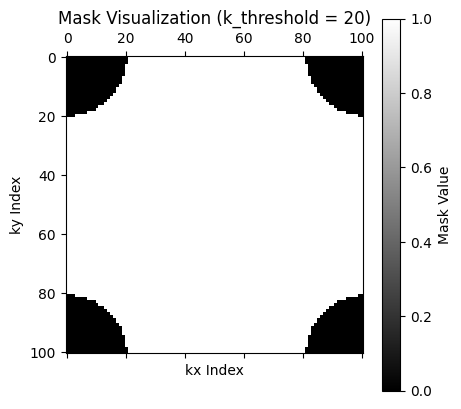

In [23]:
# Visualize the mask
plt.matshow(k_space_mask, cmap="gray")  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Mask Visualization (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

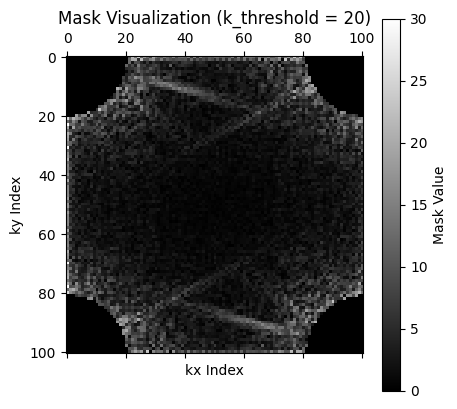

In [22]:
# Visualize the mask
plt.matshow(np.abs(k_space_mask*k_space_centered_image_manual), cmap="gray", vmin=0, vmax=30)  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Mask Visualization (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

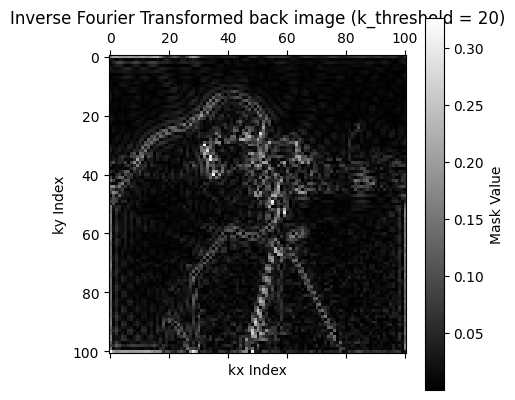

In [25]:
IFT_image = InverseFourierTransform_2d_slow(k_space_mask*k_space_centered_image_manual, x_array2, y_array2, kx_grid, ky_grid)
# Visualize the mask
plt.matshow(np.abs(IFT_image), cmap="gray")  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Inverse Fourier Transformed back image (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

In [26]:
k_space_image_tf = tf.signal.fft2d(resized_image_tf)

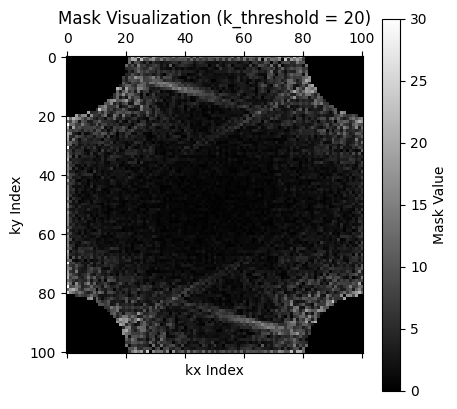

In [27]:
# Visualize the mask
plt.matshow(np.abs(k_space_mask*k_space_image_tf.numpy()), cmap="gray", vmin=0, vmax=30)  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Mask Visualization (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

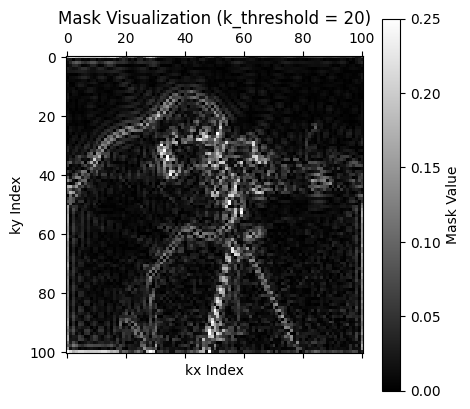

In [29]:
# Visualize the mask
plt.matshow(np.abs(tf.signal.ifft2d(tf.cast(tf.convert_to_tensor(k_space_mask), tf.complex64) * k_space_image_tf).numpy()), cmap="gray", vmin=0, vmax=0.25)  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Mask Visualization (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

In [32]:
resized_image_tf_f32 = tf.cast(tf.abs(resized_image_tf), tf.float32)

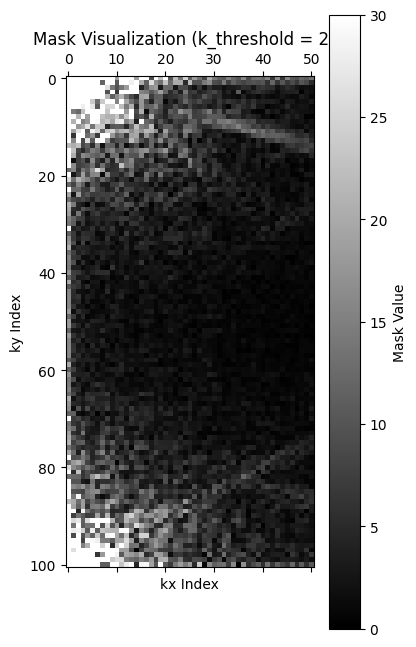

In [33]:
# Visualize the mask
plt.matshow(np.abs(tf.signal.rfft2d( resized_image_tf_f32 ).numpy()), cmap="gray", vmin=0, vmax=30)  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Mask Visualization (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

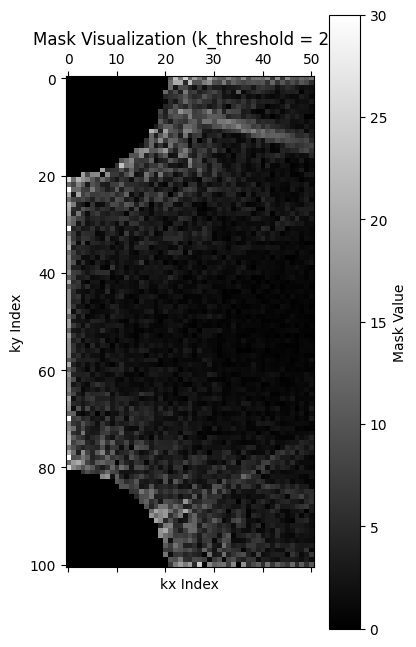

In [35]:
# Visualize the mask
plt.matshow(np.abs(tf.cast(tf.convert_to_tensor(k_space_mask), tf.complex64)[:,:51]*tf.signal.rfft2d( resized_image_tf_f32 ).numpy()), cmap="gray", vmin=0, vmax=30)  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Mask Visualization (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()

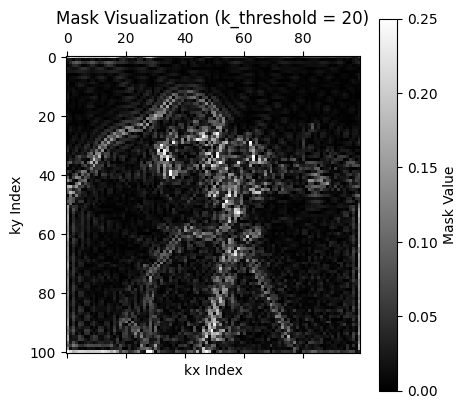

In [36]:
# Visualize the mask
plt.matshow(np.abs(tf.signal.irfft2d(tf.cast(tf.convert_to_tensor(k_space_mask), tf.complex64)[:,:51]*tf.signal.rfft2d( resized_image_tf_f32 ))), cmap="gray", vmin=0, vmax=0.25)  # 'gray' colormap: 0 is black, 1 is white
plt.colorbar(label="Mask Value")
plt.title(f"Mask Visualization (k_threshold = {k_threshold})")
plt.xlabel("kx Index")
plt.ylabel("ky Index")
plt.show()